In [1]:
from modules import expectedMultiBleu
import numpy as np
import torch
from torch.cuda import LongTensor, FloatTensor
from torch.autograd import Variable
from torch.nn import Module, functional as F
from modules.expectedBLEU import bleu as ebleu
from modules.expectedMultiBleu import bleu, calculate_overlap
from modules.matrixBLEU import mBLEU
from matplotlib import pyplot as plt
from modules.utils import CUDA_wrapper
import time
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def generate_batch_references(references_lengths, vocab_size):
    def _gen_padded_ref(l):
        ref = np.random.choice(vocab_size, size=l, replace=True)
        padding = np.array([0] * (max_len - l), dtype=int)
        return np.concatenate((ref, padding)).tolist()
    max_len = np.max(references_lengths)
    res = [_gen_padded_ref(l)\
           for l in references_lengths]
    # res = np.stack(res)
    return res

def _all_idx(idx, axis):
    print(tuple(map(slice, idx.shape)))
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

def onehot_initialization(a, vocab_size):
    ncols = vocab_size
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[_all_idx(a, axis=2)] = 1
    return out

class MySoftmax(Module):

    def forward(self, input_):
        batch_size = input_.size()[0]
        output_ = torch.stack([F.softmax(input_[i]) for i in range(batch_size)], 0)
        return output_

In [3]:
sm = MySoftmax()
np.random.seed(3)
torch.manual_seed(2)
low_len = 8
hight_len = 10
batch_size = 200
translation_len = 10
vocab_size = 20000
references_lengths = np.random.randint(low=low_len,\
                                high=hight_len + 1, size=batch_size)
t = Variable(CUDA_wrapper(\
            torch.randn((batch_size, translation_len, vocab_size))),\
    requires_grad=True)
references_batch = generate_batch_references(references_lengths, vocab_size)

In [ ]:
opt = torch.optim.Adam([t], lr=0.1)
grad_norms = []
bleu_lb = []
start_time = time.time()
for i in range(200):
    probs = sm(t)
    b = bleu(probs, references_batch, \
        LongTensor([translation_len] * batch_size), references_lengths, smooth=True)
    b[0].backward()
    bleu_lb.append(b[0].data[0])
    opt.step()
    print(b[0].data[0])
    grad_norms.append(t.grad.data.norm())
print('-'*10 + 'TIME' + '-'*10)
print(time.time() - start_time)
print('-' * 10 + ' FINAL ' + '-'* 10)
print(bleu(probs, references_batch, \
    LongTensor([translation_len] * batch_size), references_lengths, smooth=False))

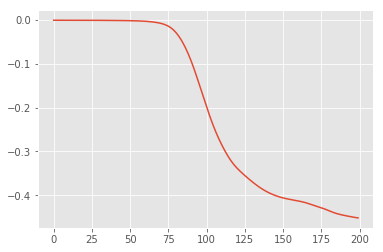

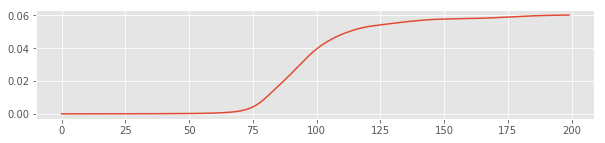

In [7]:
plt.plot(bleu_lb)
plt.show()
plt.figure(figsize=(10, 2))
plt.plot(grad_norms)
plt.show()

In [5]:
R = Variable(FloatTensor(onehot_initialization(\
                            np.array(references_batch), vocab_size).tolist()))
mbl = mBLEU()
mbl(R, probs, references_lengths, LongTensor([translation_len] * batch_size))

(slice(None, 200, None), slice(None, 10, None))


(Variable containing:
 -0.4517
 [torch.cuda.FloatTensor of size 1 (GPU 0)], [Variable containing:
   0.7448
  [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
   0.5819
  [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
   0.4041
  [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
   0.2377
  [torch.cuda.FloatTensor of size 1 (GPU 0)]])